In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model
import xgboost as xgb
import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

random.seed(10)

In [2]:
data = pd.read_csv('Data/optometry.csv')
data

,tabxneg0,age,female1,newheadache,taabnormality,jawclaudication1,platelet,discrao,diplopia1,origesr,crp
0,0,89.0,0,1,1,0,345,0,0,89.000000,0.500000
1,0,65.0,0,1,1,0,341,0,0,37.000000,6.666666
2,0,71.0,1,1,1,1,129,0,0,6.075000,0.080000
3,0,68.0,1,1,0,0,219,0,0,33.000000,0.633333
4,0,77.0,1,1,1,1,359,1,0,7.000000,0.233333
...,...,...,...,...,...,...,...,...,...,...,...
525,1,86.0,1,1,1,1,287,0,0,70.000000,48.633331
526,1,76.0,0,1,1,1,401,0,0,140.000000,37.866665
527,1,68.0,1,1,1,0,267,1,0,19.999981,3.000000
528,1,78.0,1,1,1,1,504,0,0,105.000000,70.633331


In [3]:
x = data.loc[:, data.columns != "tabxneg0"]
y = data['tabxneg0']

# 11.7a
Explore the misclassification error as a function of different values of shrinking
and interactions (number of splits), keeping a subset of 50% of variables at each
iteration (i.e., bagging = 50%). Show a graph or a table of the combinations
you tried. Which combination minimizes misclassification error? 

In [4]:
test_params = {
 'max_depth':np.arange(2, 10, 2),
 'eta': np.array([0.001, 0.005, 0.01, 0.05, 0.1])
}

model = GridSearchCV(
    estimator = xgb.XGBClassifier(objective='binary:logistic', 
                                  subsample=0.5, eval_metric='error'), 
    param_grid = test_params)
model.fit(x,y)
print(f'The combination of parameters that minimizes classification error is {model.best_params_}')

The combination of parameters that minimizes classification error is {'eta': 0.1, 'max_depth': 6}


In [5]:
cv_df = pd.DataFrame(model.cv_results_)[['params', 'mean_test_score', 
                                         'rank_test_score', 'std_test_score']]
cv_df = pd.concat([cv_df['params'].apply(pd.Series), 
                   cv_df.drop(['params'], axis=1)], axis=1)
cv_df

,eta,max_depth,mean_test_score,rank_test_score,std_test_score
0,0.001,2.0,0.749057,13,0.004622
1,0.001,4.0,0.749057,13,0.004622
2,0.001,6.0,0.749057,13,0.004622
3,0.001,8.0,0.749057,13,0.004622
4,0.005,2.0,0.749057,13,0.004622
5,0.005,4.0,0.749057,13,0.004622
6,0.005,6.0,0.749057,13,0.004622
7,0.005,8.0,0.749057,13,0.004622
8,0.010,2.0,0.775472,12,0.013865
9,0.010,4.0,0.803774,9,0.018293


In [6]:
params = {
    'objective':'binary:logistic',
    'max_depth': model.best_params_['max_depth'],
    'subsample':0.5,
    'eta': model.best_params_['max_depth'],
    'n_estimators':100,
    'eval_metric':'error'
}     
# instantiate the classifier 
xgb_clf = xgb.XGBClassifier(**params, verbosity=2)


# fit the classifier to the training data
xgb_clf.fit(x, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=6, eval_metric='error',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

# 11.7b
Create a bar chart of variable influence or variable importance for your best
model. Mention whether your graph displays influence (reduction in SS) or
importance (perturbing x-vars). Broadly speaking, is the bar chart for boosting
similar to that of random forest from 10.4? 

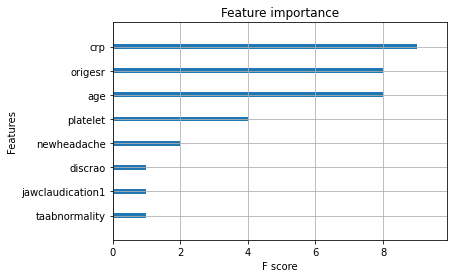

In [7]:
xgb.plot_importance(xgb_clf, show_values=False)
plt.show()

In [14]:
# Changing number of trees
test_params = {
 'n_estimators':np.arange(50, 110, 10)
}

rf_model_ne = GridSearchCV(estimator = RandomForestClassifier(
    oob_score=True, max_features='sqrt', 
     random_state=np.random.seed(2024)), param_grid = test_params)
rf_model_ne.fit(x,y)
print(f'The combination of parameters that minimizes oob error is {rf_model_ne.best_params_}, with oob error {round(1 - rf_model_ne.best_estimator_.oob_score_, 4)}')

The combination of parameters that minimizes oob error is {'n_estimators': 90}, with oob error 0.1849


In [9]:
# changing number of features
test_params = {
 'max_features': np.arange(2, 7, 1)
}
rf_model_mf = GridSearchCV(estimator = RandomForestClassifier(
    oob_score=True, n_estimators=100, random_state=np.random.seed(2024)), 
                           param_grid = test_params)
rf_model_mf.fit(x,y)
print(f'The combination of parameters that minimizes oob error is {rf_model_mf.best_params_}, with oob error {round(1 - rf_model_mf.best_estimator_.oob_score_, 4)}')

The combination of parameters that minimizes oob error is {'max_features': 4}, with oob error 0.1868


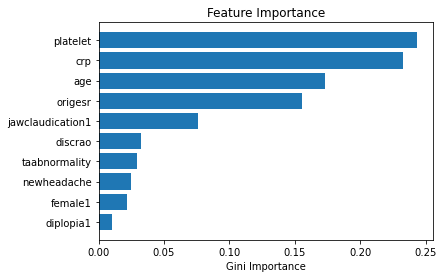

In [10]:
# Check importance based on best model from previous parameter tuning
rf_params = {
    'n_estimators': 90,
    'max_features': 'sqrt',
    'oob_score': True,
    'random_state':np.random.seed(2024)
}
rf_clf = RandomForestClassifier(**rf_params)

rf_clf.fit(x, y)
feature_importance = rf_clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(6, 4))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title('Feature Importance')
plt.xlabel('Gini Importance')
plt.show()

Here, the graph displays importance of the features. It can be observed that there are differences in the ordering of the importance of the features and the magnitude of importance. However, we cannot compare the magnitude of the importance between these two models as the importance is calculated differently. It can be observed that the top 4 most important features are the same in both models (platelet, crp, age, origesr). The XGBoost model takes less features as compared to the random forest model, female1 and diploma1 is missing.

# 11.7c
Summarize the misclassification errors from random forest 10.4, boosting,
logistic regression 4.7 with original variables, and logistic regression with the
transformed variables. Does boosting beat logistic regression on misclassification error? Why or why not?

In [11]:
lr_clf = LogisticRegression(max_iter=10000)
lr_clf.fit(x, y)
cv = RepeatedKFold(n_splits=10, n_repeats= 1, random_state=2024)
lr_scores = np.mean(cross_val_score(lr_clf, x, y, scoring='accuracy', 
                                    cv=cv, n_jobs=-1))

In [12]:
tx = x.copy()
tx[['origesr', 'crp']] = tx[['origesr', 'crp']].apply(lambda x: np.log(x))
tlr_clf = LogisticRegression(max_iter=10000)

tlr_clf.fit(tx, y)
cv = RepeatedKFold(n_splits=10, n_repeats= 1, random_state=2024)
tlr_scores = np.mean(cross_val_score(tlr_clf, tx, y, scoring='accuracy', cv=cv, n_jobs=-1))

In [13]:
print(f"Misclassification error from xgboost model {round(1-model.best_score_, 4)}")
print(f"Misclassification error from random forest {round(1 - rf_model_ne.best_estimator_.oob_score_, 4)}")
print(f"Misclassification error from logistic regression with untransformed variable {round(1-lr_scores, 4)}")
print(f"Misclassification error from logistic regression with transformed variable {round(1-tlr_scores, 4)}")

Misclassification error from xgboost model 0.1811
Misclassification error from random forest 0.1849
Misclassification error from logistic regression with untransformed variable 0.2075
Misclassification error from logistic regression with transformed variable 0.1868


It can be seen that boosting beats the other models but not by a large margin. It is better than random forest probably due to the regularization parameters in xgboost. Our data may have not been that that linear, meaning that tree methods would have been able to explain the error better. Our data may have not been explained well by a linear boundary, hence tree methods could explain them better.